In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from ipywidgets import IntProgress
from IPython.display import display

In [4]:
from model_size_calculator import ModelSizeCalculator

In [5]:
import json

In [6]:
from var_table import VarTable

In [7]:
var_table = VarTable()

In [8]:
M = 10 ** 10

In [9]:
df = pd.read_csv('dataset.csv')

In [10]:
experiments_count = len(df)

In [11]:
config = {}

In [12]:
solvers = ['glpk', 'mpec_minlp', 'cbc', 'many generations', 'two points crossover', 'large population', 'random']

In [13]:
fitnesses_dataset = {}
durations_dataset = {}

In [14]:
# fitness
for solver in solvers:
    fitnesses_dataset[solver] = []

In [15]:
# duration
for solver in solvers[:-1]:
    durations_dataset[solver] = []

In [16]:
fitnesses_dataset['variables'] = []
fitnesses_dataset['constraints'] = []

In [17]:
def find_data_by_name(dataset, name):
    for data in dataset:
        data_name = data['name']
        if data_name == name:
            return data

In [18]:
def find_solution_by_config(solutions, config):
    for solution in solutions:
        solution_config = solution['config']
        if solution_config == config:
            return solution

In [19]:
def draw_durations_polt(df):
    plt.title('durations')
    plt.xlabel('experiment')
    plt.ylabel('duration, sec')
    sns.lineplot(data=df)

In [20]:
# Переделать в комплекс круговых диаграмм
def draw_relative_fitnesses_polt(df):
    df_melted = pd.melt(df)
    title = 'fitnesses'
    sns.violinplot(x='variable', y='value', data=df_melted, width=0.7, dodge=False, hue='variable').set(title=title)
    plt.xlabel('solver')
    plt.xticks(rotation=75)
    plt.ylabel('random fitness / fitness')

In [21]:
# fitness
for experiment_number in range(experiments_count):
    nested_directory = var_table.get_nested_directory(experiment_number)
    file_path = '{}/solutions.json'.format(nested_directory)
    file = open(file_path, 'r')
    content = file.read()
    dataset = json.loads(content)
    file.close()
    for solver in solvers:
        data = find_data_by_name(dataset, solver)
        solutions = data['solutions']
        solution = find_solution_by_config(solutions, config)
        result = solution['result']
        fitness = result['fitness']
        fitnesses_dataset[solver].append(fitness)

In [22]:
# duration
for experiment_number in range(experiments_count):
    nested_directory = var_table.get_nested_directory(experiment_number)
    file_path = '{}/solutions.json'.format(nested_directory)
    file = open(file_path, 'r')
    content = file.read()
    dataset = json.loads(content)
    file.close()
    for solver in solvers[:-1]:
        data = find_data_by_name(dataset, solver)
        solutions = data['solutions']
        solution = find_solution_by_config(solutions, config)
        result = solution['result']
        duration = result['duration']
        durations_dataset[solver].append(duration)

In [23]:
progress = IntProgress(min=0, max=experiments_count, value=0, description='progress', bar_style='success')
display(progress)
for experiment_number in range(experiments_count):
    k = df['k'][experiment_number]
    l = df['l'][experiment_number]
    m = df['m'][experiment_number]
    n = df['n'][experiment_number]

    model_size_calculator = ModelSizeCalculator(k, l, m, n)
    
    variables_count = model_size_calculator.calculate_variables_count()
    constraints_count = model_size_calculator.calculate_constraints_count()
    fitnesses_dataset['variables'].append(variables_count)
    fitnesses_dataset['constraints'].append(constraints_count)
    progress.value += 1

IntProgress(value=0, bar_style='success', description='progress', max=194)

In [24]:
# fitnesses_df = pd.DataFrame(fitnesses_dataset)
# relative_fitnesses = pd.DataFrame()
# relative_fitnesses['glpk'] = fitnesses_df['glpk']
# # relative_fitnesses['cbc'] = fitnesses_df['cbc']
# # relative_fitnesses['mpec_minlp'] = fitnesses_df['mpec_minlp']
# # relative_fitnesses['single_point genetic'] = fitnesses_df['single_point genetic']
# relative_fitnesses['two points crossover'] = fitnesses_df['two points crossover']
# # relative_fitnesses['uniform genetic'] = fitnesses_df['uniform genetic']
# for i in range(len(fitnesses_df)):
#     random = fitnesses_df['random'][i]
#     relative_fitnesses['glpk'][i] = random / relative_fitnesses['glpk'][i]
#     # relative_fitnesses['cbc'][i] = random / relative_fitnesses['cbc'][i]
#     # relative_fitnesses['mpec_minlp'][i] = random / relative_fitnesses['mpec_minlp'][i]
#     # relative_fitnesses['single_point genetic'][i] = random / relative_fitnesses['single_point genetic'][i]
#     relative_fitnesses['two points crossover'][i] = random / relative_fitnesses['two points crossover'][i]
#     # relative_fitnesses['uniform genetic'][i] = random / relative_fitnesses['uniform genetic'][i]

In [25]:
# fitnesses_df

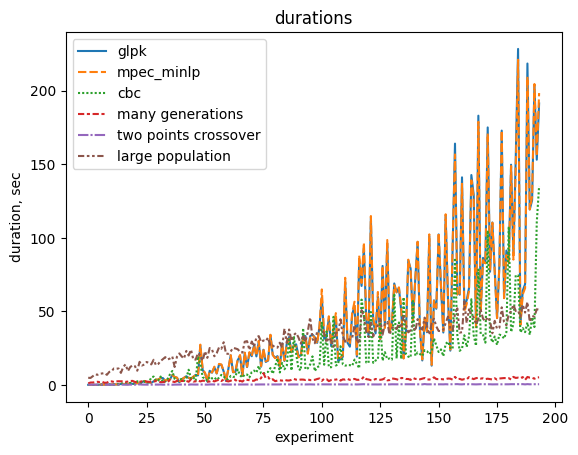

In [36]:
durations_df = pd.DataFrame(durations_dataset)
draw_durations_polt(durations_df)

In [64]:
polyfit_durations_df = pd.DataFrame()
for solver in solvers[:-1]:
    index = [i for i in durations_df.index]
    values = durations_dataset[solver]
    fp, residuals, rank, sv, rcond = np.polyfit(index, values, 2, full=True)
    f = np.poly1d(fp)
    polyfit_durations_df[solver] = f(index)

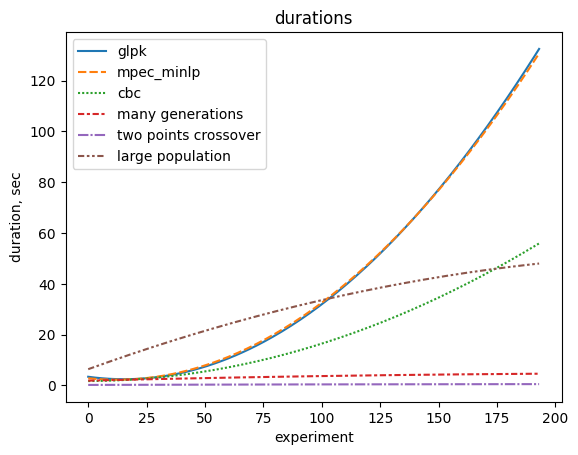

In [65]:
draw_durations_polt(polyfit_durations_df)